<a href="https://colab.research.google.com/github/aquibjaved/Deep-learning-for-text-classification/blob/master/RNN/simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from gensim import models
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 6.8MB/s 


In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '19vFHpNAuEUZIbOYrlXDRWJPOoXLMv3bX'
downloaded = drive.CreateFile({'id': file_id})

download = drive.CreateFile({'id': file_id})
download.GetContentFile('DOWNLOAD.tar')

# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [8]:
!unzip DOWNLOAD.tar 

Archive:  DOWNLOAD.tar
   creating: Deep_learning_for_text_classification/
   creating: Deep_learning_for_text_classification/embeddings/
  inflating: Deep_learning_for_text_classification/embeddings/glove.6B.50d.txt  
   creating: __MACOSX/
   creating: __MACOSX/Deep_learning_for_text_classification/
   creating: __MACOSX/Deep_learning_for_text_classification/embeddings/
  inflating: __MACOSX/Deep_learning_for_text_classification/embeddings/._glove.6B.50d.txt  
  inflating: Deep_learning_for_text_classification/.DS_Store  
  inflating: __MACOSX/Deep_learning_for_text_classification/._.DS_Store  
   creating: Deep_learning_for_text_classification/Data/
  inflating: Deep_learning_for_text_classification/Data/imdb_master.csv  
   creating: __MACOSX/Deep_learning_for_text_classification/Data/
  inflating: __MACOSX/Deep_learning_for_text_classification/Data/._imdb_master.csv  
  inflating: Deep_learning_for_text_classification/Data/.DS_Store  
  inflating: __MACOSX/Deep_learning_for_text_c

In [30]:
!pwd

/content


In [31]:
embeddings_index = {}
f = open('../content/Deep_learning_for_text_classification/embeddings/glove.6B.50d.txt')
for line in f:

    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
from numpy import zeros
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding

In [0]:
# Reading data
train_df = pd.read_csv('../content/Deep_learning_for_text_classification/Data/imdb_master.csv', encoding = "ISO-8859-1")

In [0]:
train_df = train_df.drop(["Unnamed: 0","file", "type"], axis=1)
train_df = train_df[train_df.label != 'unsup']
train_df["label"] = train_df["label"].map({"pos":1,"neg":0})

In [0]:
# Cleaning and Pre Processing text
import re

def clean_numbers(text):
    text = re.sub('[0-9]{5,}', '#####', text)
    text = re.sub('[0-9]{4}', '####', text)
    text = re.sub('[0-9]{3}', '###', text)
    text = re.sub('[0-9]{2}', '##', text)
    return text

def clean_text(text):
    text = clean_numbers(text)
    text = str(text)

    for punct in "/-'":
        text = text.replace(punct, ' ')
    for punct in '&':
        text = text.replace(punct, f' {punct} ')
    for punct in '?!.,"$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        text = text.replace(punct, '')

    text = text.lower()
    return text

In [37]:
# Clean text in dataFrame
train_df["processed_data"] = train_df["review"].progress_apply(lambda x: clean_text(x))
train_df["length"] = train_df["processed_data"].progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:00<00:00, 64391.98it/s]


In [0]:
docs = train_df["processed_data"].values
labels = train_df["label"].values

In [40]:
# Import gc, clearing some memory in ram
import gc
del train_df
gc.collect()

21

In [0]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

In [0]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)

In [0]:
# pad documents to a max length of max words
max_length = 150
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
# Create Train/Test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_docs, labels, test_size=0.2, random_state=42)

In [0]:
vocab_size = vocab_size

model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, 50, weights=[embedding_matrix], 
                                 input_length=max_length, trainable=False))

model_lstm.add(keras.layers.CuDNNLSTM((128),  return_sequences=True))
model_lstm.add(keras.layers.CuDNNLSTM((64),  return_sequences=False))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))

In [0]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 50)           7018250   
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 150, 128)          92160     
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 64)                49664     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 7,160,139
Trainable params: 141,889
Non-trainable params: 7,018,250
_________________________________________________________________


In [61]:
history = model_lstm.fit(X_train,y_train, epochs=10, validation_data=(X_test,y_test), batch_size=256)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 13s 322us/step - loss: 0.5933 - acc: 0.6840 - val_loss: 0.5360 - val_acc: 0.7444
Epoch 2/10
40000/40000 [==============================] - 12s 297us/step - loss: 0.5210 - acc: 0.7491 - val_loss: 0.4909 - val_acc: 0.7763
Epoch 3/10
40000/40000 [==============================] - 12s 296us/step - loss: 0.4706 - acc: 0.7807 - val_loss: 0.4516 - val_acc: 0.7878
Epoch 4/10
40000/40000 [==============================] - 12s 297us/step - loss: 0.4191 - acc: 0.8091 - val_loss: 0.4132 - val_acc: 0.8229
Epoch 5/10
40000/40000 [==============================] - 12s 296us/step - loss: 0.3822 - acc: 0.8284 - val_loss: 0.4111 - val_acc: 0.8118
Epoch 6/10
40000/40000 [==============================] - 12s 296us/step - loss: 0.3708 - acc: 0.8351 - val_loss: 0.3605 - val_acc: 0.8414
Epoch 7/10
40000/40000 [==============================] - 12s 296us/step - loss: 0.3514 - acc: 0.8446 - val_loss: 0.

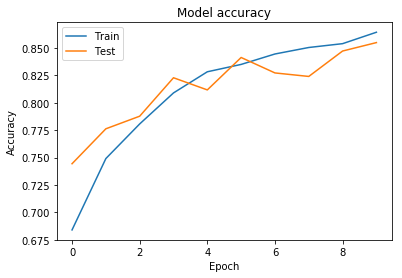

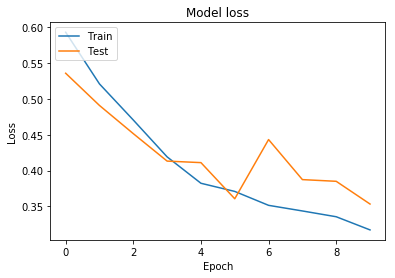

In [62]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Training Network with Gated Recurrent Unit**
 
GRU is better than LSTM as it is easy to modify and doesn't need memory units, therefore, faster to train than LSTM and give as per performance.

Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory (LSTM) with forget gate  but has fewer parameters than LSTM, as it lacks an output gate. GRU's performance on certain tasks of polyphonic music modeling and speech signal modeling was found to be similar to that of LSTM. GRUs have been shown to exhibit even better performance on certain smaller datasets.

In [0]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.Embedding(vocab_size, 50, weights=[embedding_matrix], 
                                 input_length=max_length, trainable=False))
model_gru.add(keras.layers.CuDNNGRU((128),  return_sequences=True))
model_gru.add(keras.layers.CuDNNGRU((64),  return_sequences=False))
model_gru.add(keras.layers.Dense(1, activation='sigmoid'))

In [0]:
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
model_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 50)           7018250   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 150, 128)          69120     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 7,124,683
Trainable params: 106,433
Non-trainable params: 7,018,250
_________________________________________________________________


In [55]:
history = model_gru.fit(X_train,y_train, epochs=10, validation_data=(X_test,y_test), batch_size=256)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 11s 276us/step - loss: 0.5952 - acc: 0.6684 - val_loss: 0.5423 - val_acc: 0.7435
Epoch 2/10
40000/40000 [==============================] - 10s 257us/step - loss: 0.4469 - acc: 0.7935 - val_loss: 0.4007 - val_acc: 0.8192
Epoch 3/10
40000/40000 [==============================] - 10s 257us/step - loss: 0.3850 - acc: 0.8264 - val_loss: 0.3717 - val_acc: 0.8348
Epoch 4/10
40000/40000 [==============================] - 10s 255us/step - loss: 0.3590 - acc: 0.8404 - val_loss: 0.3767 - val_acc: 0.8362
Epoch 5/10
40000/40000 [==============================] - 10s 256us/step - loss: 0.3420 - acc: 0.8495 - val_loss: 0.3801 - val_acc: 0.8390
Epoch 6/10
40000/40000 [==============================] - 10s 259us/step - loss: 0.3283 - acc: 0.8555 - val_loss: 0.3368 - val_acc: 0.8541
Epoch 7/10
40000/40000 [==============================] - 10s 256us/step - loss: 0.3076 - acc: 0.8671 - val_loss: 0.

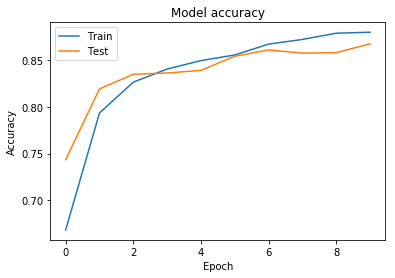

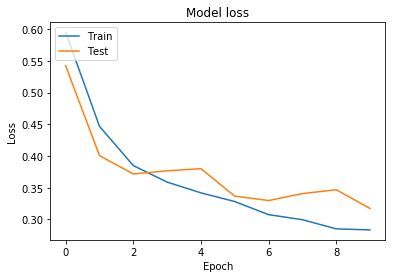

In [56]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()